# Chapter3 : Getting started with neural networks

## 3.6 Predicting house prices: a regression example

### 3.6.1 The Boston Housing Price dataset

> Using Boston Housing Price dataset you'll attempt to predict the median price of homes in a given Boston suburb in the mid-1970s.
  * The data has relatively few data points: only 506, split between 404 training samples and 102 test samples.

#### Loading the Boston housing dataset

In [3]:
from keras.datasets import boston_housing

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [4]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [5]:
train_data.shape

(404, 13)

In [6]:
import pandas as pd
pd.DataFrame(train_data).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


In [7]:
test_data.shape

(102, 13)

In [8]:
train_targets.shape

(404,)

In [9]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

In [10]:
print(min(train_targets))
print(max(train_targets))

5.0
50.0


### 3.6.2 Preparing the data

#### Normalizing the data

In [11]:
mean = train_data.mean(axis = 0)
std = train_data.std(axis = 0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

* The quantities used for **normalizing the test data are computed using the training data**. You should ***never*** use in your workflow any quantity compared on the test data, even for something as simple as data normalization.

### 3.6.3 Building your network

* Because so few samples are available, you'll use a very small network with two hidden layers, each with 64 units.

> In general, the less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting.

#### Model definition

In [12]:
from keras import models
from keras import layers

In [13]:
def build_model() :
    model = models.Sequential()
    
    model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],)))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer = 'rmsprop',
                  loss = 'mse',
                  metrics = ['mae'])    # mae (mean absolute error)
    
    return model

### 3.6.4 Validating your approach using K-fold validation

To evaluate your network while you keep adjusting its parameters, you could split the data into a training set and a validation set. But because the dataset is so small, the validation scores might change a lot depending on which data points you chose to use for validation and which you chose for training: the validation scores might have a ***high variance***. This would prevent you from reliably evaluating your model.

> The best practice in such situations is to use ***K-fold cross-validation***

#### K-fold validation

In [14]:
import numpy as np

In [15]:
k = 4
num_val_samples = len(train_data)//k
num_epochs = 10
all_scores = []

In [16]:
for i in range(k) :
    print('processing fold #', i)
    
    # prepares the validation data
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    # prepares the training data
    partial_train_data = np.concatenate(
     [train_data[:i*num_val_samples],
      train_data[(i+1)*num_val_samples:]],
     axis = 0)
    partial_train_targets = np.concatenate(
     [train_targets[:i*num_val_samples],
      train_targets[(i+1)*num_val_samples:]],
     axis = 0)
    
    # builds the keras model
    model = build_model()
    
    # fit model on the training data
    model.fit(partial_train_data, partial_train_targets,
              epochs = num_epochs,
              batch_size = 1,
              verbose = 0)   # trains the model in slient mode
    
    # evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    all_scores.append(val_mae)

processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
processing fold # 1
processing fold # 2
processing fold # 3


In [17]:
all_scores

[2.476001512886274, 2.588102640491901, 2.546693952957002, 2.805031954652012]

In [18]:
np.mean(all_scores)

2.603957515246797

* In this case, you're off by 2,600 dollars on average, which is significant considering that the prices range from 10,000 dollars to 50,000 dollars.

#### Saving the validation logs at each fold

In [19]:
num_epochs = 200
all_mae_histories = []

for i in range(k) :
    print('processing fold #', i)
    
    # prepares the validation data
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    # prepares the training data
    partial_train_data = np.concatenate(
     [train_data[:i*num_val_samples],
      train_data[(i+1)*num_val_samples:]],
     axis = 0)
    partial_train_targets = np.concatenate(
     [train_targets[:i*num_val_samples],
      train_targets[(i+1)*num_val_samples:]],
     axis = 0)
    
    # builds the keras model
    model = build_model()
    
    # fit model on the training data
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data = (val_data, val_targets),
                        epochs = num_epochs,
                        batch_size = 1,
                        verbose = 0)   # trains the model in slient mode
    
    # evaluate the model on the validation data
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


#### Building the history of successive mean K-fold validation scores

In [20]:
average_mae_history = [
     np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

In [21]:
print(np.round(average_mae_history[:5], 4))

[4.5969 3.3734 3.0917 2.922  2.8238]


#### Plotting validation scores

In [22]:
import matplotlib.pyplot as plt

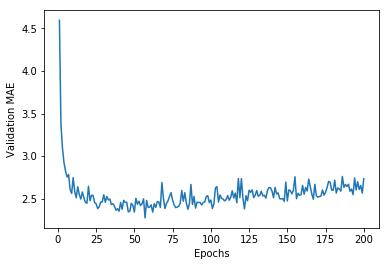

In [23]:
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

* The plot may be a little difficult to see, due to scaling issues and relatively high variance.
  + Omit the first 10 data points
  + Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

In [24]:
def smooth_curve(points, factor = 0.9) :
    smoothed_points = []
    
    for point in points :
        if smoothed_points :
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else :
            smoothed_points.append(point)
    return smoothed_points

In [25]:
smooth_mae_history = smooth_curve(average_mae_history[10:], 0.9)
print(np.round(smooth_mae_history[:5],4))

[2.5857 2.5782 2.5844 2.5808 2.5722]


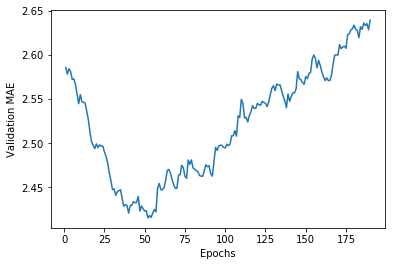

In [26]:
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

* According to the plot, validation MAE stops improving significantly after 30 epochs (MAE starts increasing after 60 epochs).
* Past that point, you start overfitting.

#### Training the final model

In [71]:
model = build_model()

model.fit(train_data, train_targets,
          epochs = 60,
          batch_size = 8,
          verbose = 0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 3ms/step


In [72]:
test_mae_score

2.5280590524860456

* The test data shows that you're still off by about 2,500 dollars.